# Building model

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import TensorBoard
from tensorboard.plugins.hparams import api as hp
import datetime


In [2]:
# build_rgb_stream
def build_rgb_stream(input_shape=(640, 640, 3), num_frames=20):
    model = models.Sequential()

    # Add convolutional layers for image processing
    model.add(layers.Conv3D(64, (3, 3, 3), activation='relu', input_shape=(num_frames,) + input_shape))
    model.add(layers.MaxPooling3D((1, 2, 2)))
    model.add(layers.Conv3D(128, (3, 3, 3), activation='relu'))
    model.add(layers.MaxPooling3D((1, 2, 2)))
    model.add(layers.Conv3D(256, (3, 3, 3), activation='relu'))
    model.add(layers.MaxPooling3D((1, 2, 2)))

    # Add TimeDistributed layer for processing each frame separately
    model.add(layers.TimeDistributed(layers.Flatten()))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))

    return model

In [3]:
# build_pose_stream
def build_pose_stream(input_shape=(20, 17*2)):
    model = models.Sequential()

    # Add LSTM layers for processing pose keypoints over time
    model.add(layers.LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(layers.LSTM(128, return_sequences=True))
    model.add(layers.LSTM(256, return_sequences=True))

    model.add(layers.Dense(256, activation='relu'))
    # model.add(layers.Dropout(0.5))

    return model


In [4]:
# build_fusion_model
def build_fusion_model(rgb_stream, pose_stream, num_classes):
    # Combine the two streams
    rgb_stream_flattened = layers.Flatten()(rgb_stream.output)
    pose_stream_flattened = layers.Flatten()(pose_stream.output)
    # combined_input = layers.concatenate([pose_stream_flattened])

    # Add fully connected layers for fusion
    fusion_dense = layers.Dense(512, activation='relu')(pose_stream_flattened) # replace with (combined_input)
    # fusion_dense = layers.Dropout(0.5)(fusion_dense)

    fusion_output = layers.Dense(num_classes, activation='sigmoid')(fusion_dense)

    # Create the final model
    fusion_model = models.Model(inputs=[pose_stream.input], outputs=fusion_output)

    return fusion_model


In [5]:
# Set the number of classes for your action recognition task
num_classes = 1

# Build the RGB stream
rgb_stream = build_rgb_stream()

# Build the Pose stream
pose_stream = build_pose_stream()

# Build the Fusion model
fusion_model = build_fusion_model(rgb_stream, pose_stream, num_classes)


# Define hyperparameters
hp_epochs = hp.HParam('epochs', hp.IntInterval(10, 50))
hp_learning_rate = hp.HParam('learning_rate', hp.RealInterval(1e-4, 1e-2))

# Create a summary file for TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Create a callback for hyperparameter logging
hparams_callback = hp.KerasCallback(log_dir, hparams={hp_epochs: 20, hp_learning_rate: 1e-3})


# Compile the model with an appropriate optimizer, loss, and metrics
fusion_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy', 'binary_accuracy'])

# Display the model summary
fusion_model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_input (InputLayer)     [(None, 20, 34)]          0         
                                                                 
 lstm (LSTM)                 (None, 20, 64)            25344     
                                                                 
 lstm_1 (LSTM)               (None, 20, 128)           98816     
                                                                 
 lstm_2 (LSTM)               (None, 20, 256)           394240    
                                                                 
 dense_1 (Dense)             (None, 20, 256)           65792     
                                                                 
 flatten_2 (Flatten)         (None, 5120)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               2621

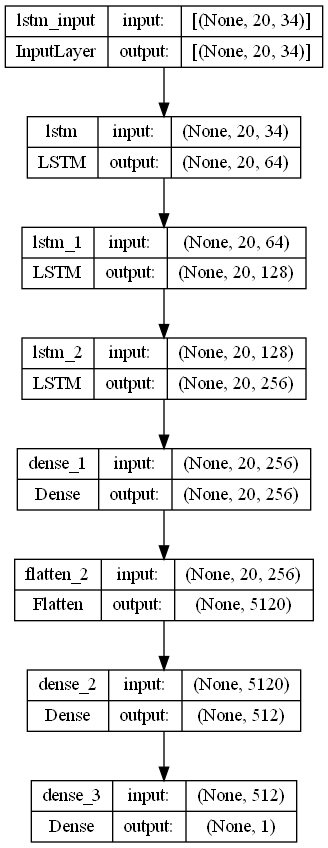

In [6]:
tf.keras.utils.plot_model(fusion_model, to_file='model_plot.png',
                           show_shapes=True, show_layer_names=True)

In [7]:
fusion_model.input_shape

(None, 20, 34)

# Prepare Dataset


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [9]:
#df = pd.read_csv('keypoint_dataset/keypoints_df_20240128_002652.csv') #the first Dataset
df = pd.read_csv('keypoint_dataset/keypoints_df_20240202_103509.csv')  #the second Dataset
df[:2]

,0,0.1
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.46...",WalkingWithDog
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",WalkingWithDog


In [10]:
df.columns = ['keypoints', 'target']

In [11]:
df['keypoints'] = df['keypoints'].apply(lambda x: np.asarray(eval(x)) if type(x)==str else np.zeros((20, 34)))
# df['0'] = df['0'].apply(lambda arr: np.pad(arr, ((0, max(0, 20 - arr.shape[0])), (0, 0)), mode='constant', constant_values=0))

In [12]:
df['target'] = df['target'].apply(lambda x: 0 if x=='WalkingWithDog' else 1)

In [13]:
df['target'].value_counts()

target
1    2680
0     450
Name: count, dtype: int64

# Augment data

In [14]:
# df.drop([ '1', '2', '3', '4', '0.1', '0.2'], axis=1, inplace=True)

In [15]:
keypoints_array = np.asarray(df['keypoints'])

# Check the shape of the entire 'keypoints' array
print(keypoints_array.shape)

(3130,)


In [16]:
from sklearn.model_selection import train_test_split
X = np.asarray(df['keypoints'].tolist())
y = np.asarray(df['target']).astype('float32')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [17]:
import tensorflow as tf

In [18]:

history = fusion_model.fit(
    X_train,  # Replace rgb_data and pose_data with your actual training data
    y_train,  # Replace labels with your actual training labels
    epochs=50,
    callbacks=[tensorboard_callback, hparams_callback],
    validation_split=0.2  # Set the validation split as needed
)

# Launch TensorBoard for real-time visualization
%tensorboard --logdir logs/fit

Epoch 1/50


55/55 [==============================] - 6s 50ms/step - loss: 0.4097 - accuracy: 0.8436 - binary_accuracy: 0.8436 - val_loss: 0.3299 - val_accuracy: 0.8815 - val_binary_accuracy: 0.8815
Epoch 2/50
55/55 [==============================] - 2s 39ms/step - loss: 0.3554 - accuracy: 0.8596 - binary_accuracy: 0.8596 - val_loss: 0.3155 - val_accuracy: 0.8815 - val_binary_accuracy: 0.8815
Epoch 3/50
55/55 [==============================] - 2s 37ms/step - loss: 0.3487 - accuracy: 0.8596 - binary_accuracy: 0.8596 - val_loss: 0.3831 - val_accuracy: 0.8815 - val_binary_accuracy: 0.8815
Epoch 4/50
55/55 [==============================] - 2s 38ms/step - loss: 0.3499 - accuracy: 0.8596 - binary_accuracy: 0.8596 - val_loss: 0.3237 - val_accuracy: 0.8815 - val_binary_accuracy: 0.8815
Epoch 5/50
55/55 [==============================] - 2s 40ms/step - loss: 0.3445 - accuracy: 0.8596 - binary_accuracy: 0.8596 - val_loss: 0.3138 - val_accuracy: 0.8815 - val_binary_accuracy: 0.8815
Epoch 6/50
55

KeyboardInterrupt: 

In [ ]:
fusion_model.save('models/detector2.keras', overwrite=False)

[TIP] Next time specify overwrite=True!


In [33]:
X[0].shape

(20, 34)

<Axes: >

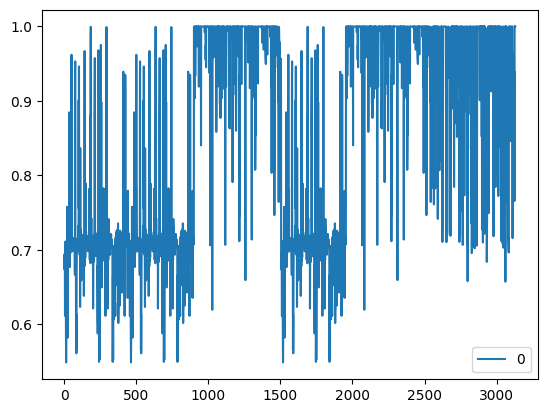

In [35]:
pd.DataFrame(fusion_model(np.array(X))).plot()

In [23]:
X[200:210].shape

(10, 20, 34)

In [52]:

print(fusion_model(np.array(X[200:205])))

tf.Tensor(
[[0.61548716]
 [0.6404425 ]
 [0.63436747]
 [0.63190275]
 [0.64873147]], shape=(5, 1), dtype=float32)


In [26]:
# load model
from keras.models import load_model
model = load_model('models/detector.keras')

In [30]:
X[:10].shape

(10, 20, 34)

In [36]:
model.predict(X[:10])

1/1 [==============================] - 0s 13ms/step


array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]], dtype=float32)

In [37]:
model